In [1]:
# Import packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
import random
from scipy import signal
from copy import copy, deepcopy
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Pre - processing Functions

In [2]:
#Force Divider Function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

#FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

## Load Old Dataset

The old dataset has three kinds of data: Drop, Squeeze and Nothing. After running this cell below, it is loaded into the variable named dataset.

In [3]:
#thank you Sala for your 7 second cropped data 
string = '/Users/swarup/Desktop/BEST Lab/combined/old_data/test'
dataset = []
file_numbers = np.arange(1,73) 

for num in file_numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    d = d.drop(columns = ["IND"])
    d = d.to_numpy()
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    

    #interpolation for even time steps 
    length = np.shape(d)[0] 
    new_t = np.linspace(d[0,0],d[length-1,0],length,endpoint = True)
    for col in np.arange(1,16):
        single_FSR = d[:,col]
        time = d[:,0]
        function = interp1d(time, single_FSR)
        new_data = function(new_t)
        d[:,col] = new_data 
    d[:,0] = new_t
#     print(np.shape(d[0]))
    dataset.append(d)
    
print(np.shape(dataset))

(72, 7001, 16)


## Load New Dataset

The new datat sets consists of Drop , Squeeze , Handle, Roll and Nothing Data. Running the cell below loads it into the respective variables newDrop, newHandle , newRoll, newSqueeze , newNothing.

In [4]:
# Labels
    # Drop = 1 (starts at ind 0)
    # Handle = 2 (starts at ind 21)
    # Roll = 3 (starts at ind 73)
    # Squeeze = 4 (starts at ind 88)
    # Nothing = 5 (starts at ind 178)

newDrop = []
newHandle = []
newRoll = []
newSqueeze = []
newNothing = []

    
# Add Drop data
string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Drop/drop"
numbers = np.arange(1,21)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    d = d.drop(columns = ["IND"])
    d = d.to_numpy()
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newDrop.append(d)
    
# Add Handle data
string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Handle/handleTest"
numbers = np.arange(1, 53)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    
    d = d.drop(columns = ["Nothing", "IND", "QUAT_W", "QUAT_X", "QUAT_Y","QUAT_Z"])
    
    d = d[["time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
            "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
            "ACC_X", "ACC_Y", "ACC_Z"]]
    
    d = d.to_numpy()
    
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newHandle.append(d)

# Add Roll data
string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Roll/rollTest"
numbers = np.arange(1, 15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
   
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    
    d = d.drop(columns = ["Nothing", "IND", "QUAT_W", "QUAT_X", "QUAT_Y","QUAT_Z"])
    
    d = d[["time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
            "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
            "ACC_X", "ACC_Y", "ACC_Z"]]
    
    d = d.to_numpy()
    
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newRoll.append(d)


    
# Add Squeeze data

string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Squeeze/squeeze"
numbers = np.arange(56, 90)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    
    d = d.drop(columns = ["IND"])
    
    d = d[["time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
            "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
            "ACC_X", "ACC_Y", "ACC_Z"]]
    
    d = d.to_numpy()
    
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newSqueeze.append(d)
    

    
# Add More Squeeze data
string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Squeeze/squeeze"
numbers = np.arange(1, 56)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    
    d = d.drop(columns = ["Nothing", "IND", "QUAT_W", "QUAT_X", "QUAT_Y","QUAT_Z"])
    
    d = d[["time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
            "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
            "ACC_X", "ACC_Y", "ACC_Z"]]
    
    d = d.to_numpy()
    
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newSqueeze.append(d)
    
    
# Add Nothing data
string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Nothing/nothing"
numbers = np.arange(48, 57)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    
    d = d.drop(columns = ["IND"])
    
    d = d[["time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
            "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
            "ACC_X", "ACC_Y", "ACC_Z"]]
    
    d = d.to_numpy()
    
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newNothing.append(d)
    

# Add More Nothing data
string = "/Users/swarup/Desktop/BEST Lab/combined/new_data/Nothing/nothing"

numbers = np.arange(2, 48)

for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    
    d["time"] = d["time"].apply(lambda x: (x - d["time"][0])*1e-6)   #convert time to seconds
    
    d = d.drop(columns = ["Nothing", "IND", "QUAT_W", "QUAT_X", "QUAT_Y","QUAT_Z"])
    
    d = d[["time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
            "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
            "ACC_X", "ACC_Y", "ACC_Z"]]
    
    d = d.to_numpy()
    
    d[:,1:13] = force_divider(FSR_model(d[:,1:13] *5/1023)) #convert force from raw data to newtons
    
    newNothing.append(d)

In [9]:
print(len(newDrop))
print(len(newHandle))
print(len(newRoll))
print(len(newSqueeze))
print(len(newNothing))

20
52
14
89
55


The below cell specificies indices for the 72 sets in the old dataset. The first set of indices is the nothing data, then is drop data and lastly squeeze data.

In [27]:
indices_dict = {}
indices_dict[1] = [[], [], []]
indices_dict[2] = [[], [], []]
indices_dict[3] = [[], [], []]
indices_dict[4] = [[[0, 750], [2301, 2750], [4101, 4550], [6201, 7001]], [], [[751, 2300], [2751, 4100], [4551, 6200]]]
indices_dict[5] = [[[0, 900], [1501, 3300], [3901, 5700], [6301, 7001]], [], [[901, 1500], [3301, 3900], [5701, 6300]]]
indices_dict[6] = [[[0, 1100], [1751, 2750], [3401, 4400], [5101, 7001]], [], [[1101, 1750], [2751, 3400], [4401, 5100]]]
indices_dict[7] = [[[0, 1700], [2501, 3000], [3651, 4250], [5051, 7001]], [], [[1701, 2500], [3001, 3650], [4251, 5050]]]
indices_dict[8] = [[[0, 1500], [2151, 2650], [3326, 3850], [4551, 7001]], [], [[1501, 2150], [2651, 3325], [3851, 4550]]]
indices_dict[9] = [[[0, 2200], [2851, 3450], [4151, 4600], [5301, 7001]], [], [[2201, 2850], [3451, 4150], [4601, 5300]]]
indices_dict[10] = [[], [], []]
indices_dict[11] = [[], [], []]
indices_dict[12] = [[[0, 1000], [2501, 3000], [4251, 5000], [6301, 7001]], [], [[1001, 2500], [3001, 4250], [5001, 6300]]]
indices_dict[13] = [[], [], []] #todo
indices_dict[14] = [[], [], []] #todo
indices_dict[15] = [[], [], []] #todo
indices_dict[16] = [[], [], []] #todo
indices_dict[17] = [[], [], []] #todo
indices_dict[18] = [[[0, 2100], [3801, 7001]], [[2101, 3800]], []]
indices_dict[19] = [[[0, 1700], [3101, 7001]], [[1701, 3100]], []]
indices_dict[20] = [[], [], []] #this data seems messed up 
indices_dict[21] = [[], [], []] #this data seems messed up 
indices_dict[22] = [[[0, 2600], [4051, 7001]], [[2601, 4050]], []]
indices_dict[23] = [[[0, 1850], [3651, 7001]], [[1851, 3650]], []]
indices_dict[24] = [[[0, 2250], [4501, 7001]], [[2251, 4500]], []]
indices_dict[25] = [[[0, 2500], [4051, 7001]], [[2501, 4050]], []]
indices_dict[26] = [[], [], []] #node
indices_dict[27] = [[[0, 2850], [4601, 7001]], [[2851, 4600]], []]
indices_dict[28] = [[[0, 3000], [4601, 7001]], [[3001, 4600]], []]
indices_dict[29] = [[[0, 1500], [3251, 7001]], [[1501, 3250]], []]
indices_dict[30] = [[[0, 1900], [3001, 7001]], [[1901, 3000]], []]
indices_dict[31] = [[[0, 1950], [3701, 7001]], [[1951, 3700]], []]
indices_dict[32] = [[[0, 2650], [4251, 7001]], [[2651, 4250]], []]
indices_dict[33] = [[], [], []] #sensor failures
indices_dict[34] = [[], [], []] #sensor failures
indices_dict[35] = [[[0, 2000], [4801, 7001]], [], [[2001, 4800]]]
indices_dict[36] = [[[0, 2000], [5501, 7001]], [], [[2001, 5500]]]
indices_dict[37] = [[], [], []] #node
indices_dict[38] = [[[0, 7701]], [], []] #only nothing data
indices_dict[39] = [[[0, 1100], [2301, 2500], [3801, 4050], [5301, 7001]], [], [[1101, 2300], [2501, 3800], [4051, 5300]]]
indices_dict[40] = [[], [], []] #sensor failures
indices_dict[41] = [[], [], []] #sensor failures
indices_dict[42] = [[], [], []] #sensor failures
indices_dict[43] = [[], [], []] #sensor failures
indices_dict[44] = [[], [], []] #sensor failures
indices_dict[45] = [[], [], []] #sensor failures
indices_dict[46] = [[], [], []] #sensor failures
indices_dict[47] = [[[0, 2000], [2901, 3250], [4251, 4500], [5501, 7001]], [], [[2001, 2900], [3251, 4250], [4501, 5500]]]
indices_dict[48] = [[[0, 1800], [2751, 3250], [4001, 4500], [5251, 7001]], [], [[1801, 2750], [3251, 4000], [4501, 5250]]]
indices_dict[49] = [[], [], []] #sensor failures
indices_dict[50] = [[[0, 1800], [2601, 3000], [3851, 4200], [5101, 7001]], [], [[1801, 2600], [3001, 3850], [4201, 5100]]]
indices_dict[51] = [[], [], []] #todo
indices_dict[52] = [[], [], []] #todo
indices_dict[53] = [[], [], []] #todo
indices_dict[54] = [[], [], []] #todo
indices_dict[55] = [[], [], []] #todo
indices_dict[56] = [[], [], []] #todo
indices_dict[57] = [[], [], []] #todo
indices_dict[58] = [[], [], []] #todo
indices_dict[59] = [[], [], []] #todo
indices_dict[60] = [[], [], []] #todo
indices_dict[61] = [[], [], []] #todo
indices_dict[62] = [[], [], []] #todo
indices_dict[63] = [[], [], []] #todo
indices_dict[64] = [[], [], []] #todo
indices_dict[65] = [[], [], []] #todo
indices_dict[66] = [[], [], []] #todo
indices_dict[67] = [[], [], []] #todo
indices_dict[68] = [[], [], []] #todo
indices_dict[69] = [[], [], []] #todo
indices_dict[70] = [[], [], []] #todo
indices_dict[71] = [[], [], []] #todo
indices_dict[72] = [[], [], []] #todo

The function below creates a datset given a certian window size. It slides over the datapoint and creates samples according to the window size.

In [28]:
def create_dataset(window_size):
    nothing = []
    drop = []
    squeeze = []
    handle = []
    roll = []
    
    
    print('Window Size= ' + str(window_size))
    for n in np.arange(1,72):
        indices = indices_dict[n]
        data = dataset[n]
        for l in indices[0]: #cropping for nothing data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                nothing.append(crop)
                start1+=window_size
                stop1+=window_size
        for l in indices[1]: #cropping for drop data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                drop.append(crop)
                start1+=window_size
                stop1+=window_size
        for l in indices[2]: #cropping for squeeze data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                squeeze.append(crop)
                start1+=window_size
                stop1+=window_size
                
                
    for sample in newNothing:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                nothing.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newHandle:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                handle.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newDrop:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                drop.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newSqueeze:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                squeeze.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newRoll:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                roll.append(crop)
                start1+=window_size
                stop1+=window_size
                
                
    final_data = nothing+drop+squeeze+handle+roll
    
    #create labels 
    #nothing = 1
    #drop = 2
    #squeeze = 3
    nothing_labels = [1] * len(nothing)
    print('Number of nothing data: ' + str(len(nothing_labels)))
    drop_labels = [2] * len(drop)
    print('Number of drop data: ' + str(len(drop_labels)))
    squeeze_labels = [3] * len(squeeze)
    print('Number of squeeze data: ' + str(len(squeeze_labels)))
    
    handle_labels = [4] * len(handle)
    print('Number of Handle data: ' + str(len(handle_labels)))
    
    roll_labels = [5] * len(roll)
    print('Number of Roll data: ' + str(len(roll_labels)))
    
    labels = nothing_labels + drop_labels + squeeze_labels + handle_labels + roll_labels
    
    print(np.shape(labels))
    return final_data, labels

In [29]:
def create_dataset_noroll(window_size):
    nothing = []
    drop = []
    squeeze = []
    handle = []
    
    
    print('Window Size= ' + str(window_size))
    for n in np.arange(1,72):
        indices = indices_dict[n]
        data = dataset[n]
        for l in indices[0]: #cropping for nothing data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                nothing.append(crop)
                start1+=window_size
                stop1+=window_size
        for l in indices[1]: #cropping for drop data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                drop.append(crop)
                start1+=window_size
                stop1+=window_size
        for l in indices[2]: #cropping for squeeze data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                squeeze.append(crop)
                start1+=window_size
                stop1+=window_size
                
                
    for sample in newNothing:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                nothing.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newHandle:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                handle.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newDrop:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                drop.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newSqueeze:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                squeeze.append(crop)
                start1+=window_size
                stop1+=window_size
                
                
    final_data = nothing+drop+squeeze+handle
    
    #create labels 
    #nothing = 1
    #drop = 2
    #squeeze = 3
    nothing_labels = [1] * len(nothing)
    print('Number of nothing data: ' + str(len(nothing_labels)))
    drop_labels = [2] * len(drop)
    print('Number of drop data: ' + str(len(drop_labels)))
    squeeze_labels = [3] * len(squeeze)
    print('Number of squeeze data: ' + str(len(squeeze_labels)))
    
    handle_labels = [4] * len(handle)
    print('Number of Handle data: ' + str(len(handle_labels)))
    
    
    labels = nothing_labels + drop_labels + squeeze_labels + handle_labels
    
    print(np.shape(labels))
    return final_data, labels

In [13]:
def create_dataset_norollhandle(window_size):
    nothing = []
    drop = []
    squeeze = []
    handle = []
    
    
    print('Window Size= ' + str(window_size))
    for n in np.arange(1,72):
        indices = indices_dict[n]
        data = dataset[n]
        for l in indices[0]: #cropping for nothing data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                nothing.append(crop)
                start1+=window_size
                stop1+=window_size
        for l in indices[1]: #cropping for drop data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                drop.append(crop)
                start1+=window_size
                stop1+=window_size
        for l in indices[2]: #cropping for squeeze data
            start = l[0]
            stop = l[1]
            cropped = data[start:stop, :]
            start1 = random.randint(0, len(cropped)%window_size)
            stop1 = window_size+start1
            while stop1 <= len(cropped):
                crop = cropped[start1:stop1, :]
                squeeze.append(crop)
                start1+=window_size
                stop1+=window_size
                
                
    for sample in newNothing:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                nothing.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newDrop:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                drop.append(crop)
                start1+=window_size
                stop1+=window_size
                
    for sample in newSqueeze:
        start1 = random.randint(0, len(sample)%window_size)
        stop1 = window_size+start1
        while stop1 <= len(sample):
                crop = sample[start1:stop1, :]
                squeeze.append(crop)
                start1+=window_size
                stop1+=window_size
                
                
    final_data = nothing+drop+squeeze
    
    #create labels 
    #nothing = 1
    #drop = 2
    #squeeze = 3
    nothing_labels = [1] * len(nothing)
    print('Number of nothing data: ' + str(len(nothing_labels)))
    drop_labels = [2] * len(drop)
    print('Number of drop data: ' + str(len(drop_labels)))
    squeeze_labels = [3] * len(squeeze)
    print('Number of squeeze data: ' + str(len(squeeze_labels)))

    
    labels = nothing_labels + drop_labels + squeeze_labels
    
    print(np.shape(labels))
    return final_data, labels

The next cell fits a Random Forest, Naive Bayes and a Support Vector Machine. It tries different window sizes and then plots a graph of accuracies against window sizes for the different models.

In [14]:
#USING RAW DATA 

NBaccuracies = []
RFaccuracies = []
SVMaccuracies = []

windows = np.arange(20, 100, 10)
for w in windows:
    final_data, labels = create_dataset_norollhandle(w)
    print(np.shape(final_data))
    nsamples, nx, ny = np.shape(final_data)
    reformated_data = np.reshape(final_data,(nsamples, nx*ny))
    [X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)
    nb = GaussianNB().fit(X_train, y_train)
    nbs = nb.score(X_test, y_test)
    NBaccuracies.append(nbs)
    rf = RandomForestClassifier().fit(X_train, y_train)
    rfs = rf.score(X_test, y_test)
    RFaccuracies.append(rfs)
    sv = SVC().fit(X_train, y_train)
    svs = sv.score(X_test, y_test)
    SVMaccuracies.append(svs)
    print("NB: ", nbs, " RF: ", rfs, " SVM: ", svs)
    
    
plt.plot(windows,NBaccuracies)
plt.plot(windows, RFaccuracies)
plt.plot(windows, SVMaccuracies)
plt.xlabel('window size')
plt.ylabel('accuracy')
plt.legend('nb', 'rf')

f = np.polyfit(windows, NBaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

f = np.polyfit(windows, RFaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

f = np.polyfit(windows, SVMaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

plt.show()

Window Size= 20
Number of nothing data: 11924
Number of drop data: 7976
Number of squeeze data: 14117
(34017,)
(34017, 20, 16)
NB:  0.5207524985302763  RF:  0.9325102880658436  SVM:  0.7724867724867724
Window Size= 30
Number of nothing data: 7924
Number of drop data: 5310
Number of squeeze data: 9385
(22619,)
(22619, 30, 16)
NB:  0.5283819628647215  RF:  0.916710875331565  SVM:  0.7720601237842617
Window Size= 40
Number of nothing data: 5929
Number of drop data: 3984
Number of squeeze data: 7037
(16950,)
(16950, 40, 16)
NB:  0.5212364322793771  RF:  0.9093912222746579  SVM:  0.7701746106654083
Window Size= 50
Number of nothing data: 4746
Number of drop data: 3182
Number of squeeze data: 5608
(13536,)
(13536, 50, 16)


KeyboardInterrupt: 

The next cell does the same things for without roll data.

<ipython-input-48-0de9ae12d013>:19: UserWarning: Legend does not support 'n' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('nb', 'rf')
<ipython-input-48-0de9ae12d013>:19: UserWarning: Legend does not support 'b' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('nb', 'rf')


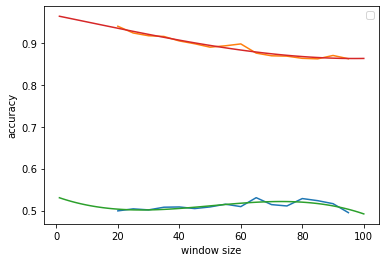

In [48]:
NBaccuracies = []
RFaccuracies = []
windows = np.arange(20, 100, 5)
for w in windows:
    final_data, labels = create_dataset_noroll(w)
    print(np.shape(final_data))
    nsamples, nx, ny = np.shape(final_data)
    reformated_data = np.reshape(final_data,(nsamples, nx*ny))
    [X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)
    nb = GaussianNB().fit(X_train, y_train)
    NBaccuracies.append(nb.score(X_test, y_test))
    rf = RandomForestClassifier().fit(X_train, y_train)
    RFaccuracies.append(rf.score(X_test, y_test))
    
    
plt.plot(windows,NBaccuracies)
plt.plot(windows, RFaccuracies)
plt.xlabel('window size')
plt.ylabel('accuracy')
plt.legend('nb', 'rf')

f = np.polyfit(windows, NBaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

f = np.polyfit(windows, RFaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

plt.show()

In [16]:
#feature function block 
def impulse(data_matrix):
    #total impulse function for a single matrix of data 
    #iterates over data and computes the total impulse for all sensors over time 
    fsr_data = data_matrix[:,1:13]
    impulse = 0
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1]- time[i]
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef*delta_t
    return impulse 

def jerk(data_matrix): 
    #iterates over data and computes the max jerk for each sensor over time
    #takes the max jerk over all FSR sensors and returns  
    fsr_data = data_matrix[:,1:13]
    jerk_array = []
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        all_jerks = []
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1] - time[i]
            delta_f = single_FSR[i+1] - single_FSR[i]
            all_jerks.append(delta_f/delta_t)
        jerk_array.append(np.amax(all_jerks))
    max_jerk = np.amax(jerk_array)
    return max_jerk

def max_force(data_matrix):
    #max force readings across all sensors for a single matrix of data 
    fsr_data = data_matrix[:,1:13]
    force_array = [] 
    for col in np.arange(1,13):
        single_FSR = data_matrix[:,col]
        max_force_sensor = np.amax(single_FSR)
        force_array.append(max_force_sensor)
    max_force = np.amax(force_array)
    return max_force

<ipython-input-24-707f2a1c2cdd>:27: UserWarning: Legend does not support 'n' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('nb', 'rf')
<ipython-input-24-707f2a1c2cdd>:27: UserWarning: Legend does not support 'b' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('nb', 'rf')


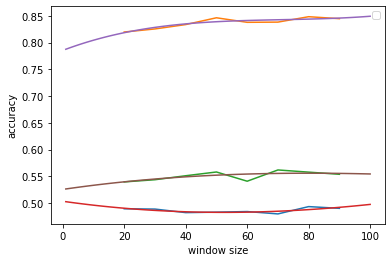

In [24]:
#USING Features 
NBaccuracies = []
RFaccuracies = []
SVMaccuracies = []

windows = np.arange(20, 100, 10)
for w in windows:
    final_data, labels = create_dataset_norollhandle(w)
    final_data_features = []
    for d in final_data: 
        final_data_features.append([impulse(d), jerk(d), max_force(d)])
    print(np.shape(final_data_features))
    [X_train, X_test, y_train, y_test] = train_test_split(final_data_features, labels, random_state=0)
    nb = GaussianNB().fit(X_train, y_train)
    NBaccuracies.append(nb.score(X_test, y_test))
    rf = RandomForestClassifier().fit(X_train, y_train)
    RFaccuracies.append(rf.score(X_test, y_test))
    sv = SVC().fit(X_train, y_train)
    svs = sv.score(X_test, y_test)
    SVMaccuracies.append(svs)
    
plt.plot(windows,NBaccuracies)
plt.plot(windows, RFaccuracies)
plt.plot(windows, SVMaccuracies)
plt.xlabel('window size')
plt.ylabel('accuracy')
plt.legend('nb', 'rf')

f = np.polyfit(windows, NBaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

f = np.polyfit(windows, RFaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

f = np.polyfit(windows, SVMaccuracies, 3)
p = np.poly1d(f)
new_x = np.linspace(1,100, 100)
plt.plot(new_x, p(new_x))

plt.show()

In [25]:
print(RFaccuracies)

[0.8197530864197531, 0.8254641909814323, 0.8336479471448797, 0.8463356973995272, 0.837847469707769, 0.8382413936126089, 0.8483547925608012, 0.8446601941747572]


In [26]:
print(len(RFaccuracies))

8
